### Import necessary packages and read data into dataframe

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Used for determining days of the week
import datetime
# Used for isnan()
import math
from pathlib import Path

from scipy.stats import pearsonr

from scipy.stats import spearmanr

In [2]:
Xtest = pd.read_csv(Path('data/Xtest.csv'))
Xtrain = pd.read_csv(Path('data/Xtrain.csv'))
Ytrain = pd.read_csv(Path('data/Ytrain.csv'))
Ysample = pd.read_csv(Path('data/Ysample.csv'))

# Exploratory Data Analysis

### The data is split into 12 variables; 6 contextual variables and 6 lag variables. The contextual variables are going to be analyzed first:

* Date: The date the data was collected.
* Train: An ID (unique by day) between 1 and 55 (inclusive).
* Station: The ID of the station where the data was collected.
* Hour: The hour (in format HH:00:00, 24 hour time) the data was collected.
* Way: Whether the train is heading towards Paris (0) or away from Paris (1).
* Composition: The number of train units, 1 or 2.

Number of unique dates: 74


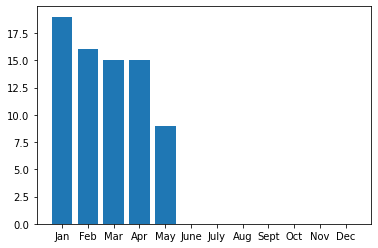

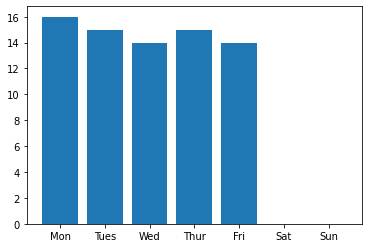

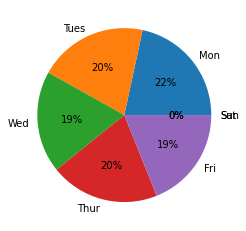

In [3]:
dates = []
dateCount = 0
months = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
days = [0, 0, 0, 0, 0, 0, 0]
temp = 0

for i in Xtrain["date"]:
    if i not in dates:
        dates.append(i)
        dateCount += 1
        
dates.sort()
print("Number of unique dates: " + str(dateCount))
#print("List of unique dates (in chronological order):")
#print(dates)

for i in dates:
    temp = int(i[5:7])
    months[temp - 1] += 1

plt.bar(["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"], months)
plt.show()

for i in dates:
    temp = datetime.datetime(int(i[0:4]), int(i[5:7]), int(i[8:10])).weekday()
    days[temp] += 1

plt.bar(["Mon", "Tues", "Wed", "Thur", "Fri", "Sat", "Sun"], days)
plt.show()
plt.pie(days, labels=["Mon", "Tues", "Wed", "Thur", "Fri", "Sat", "Sun"], autopct='%.0f%%')
plt.show()

In [4]:
trains = []
trainCount = 0

for i in Xtrain["train"]:
    if i not in trains:
        trains.append(i)
        trainCount += 1
        
trains.sort()
print("Number of unique trains: " + str(trainCount))
print("List of stations (in numerical order): " + str(trains))

Number of unique trains: 55
List of stations (in numerical order): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]


In [5]:
stations = []
stationCount = 0

for i in Xtrain["station"]:
    if i not in stations:
        stations.append(i)
        stationCount += 1
        
stations.sort()
print("Number of stations: " + str(stationCount))
print("List of stations (in alphabetical order): " + str(stations))

Number of stations: 36
List of stations (in alphabetical order): ['AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AJ', 'AK', 'AL', 'AM', 'AN', 'AO', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AU', 'AV', 'AW', 'AX', 'AY', 'AZ', 'BA', 'BB', 'BC', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ']


In [6]:
hours = []
hourCount = 0
hoursIsNan = 0
hoursIsntNan = 0

for i in Xtrain["hour"]:
    if i not in hours:
        hours.append(i)
        hourCount += 1
        
    if str(i)[0:3] == "nan":
        hoursIsNan += 1
    else:
        hoursIsntNan += 1
    
print("Number of unique hour slots: " + str(hourCount))
print("List of hours: " + str(hours))
print("Note: nan stands for \"Not a Number\" and therefore represents a missing value.")
print("% of missing values: " + str(round((hoursIsNan / (hoursIsNan + hoursIsntNan)), 4) * 100))

Number of unique hour slots: 6
List of hours: ['06:00:00', '07:00:00', nan, '08:00:00', '09:00:00', '11:00:00']
Note: nan stands for "Not a Number" and therefore represents a missing value.
% of missing values: 10.299999999999999


In [7]:
numToParis = 0
numFromParis = 0

for i in Xtrain["way"]:
    if i == 0:
        numToParis += 1
    else:
        numFromParis += 1

print("Number of trains to Paris:   " + str(numToParis))
print("Number of trains from Paris: " + str(numFromParis))
print("% of trains with going to Paris: " + str(round((numToParis / (numToParis + numFromParis)), 4) * 100))

Number of trains to Paris:   31119
Number of trains from Paris: 0
% of trains with going to Paris: 100.0


In [8]:
numOfCompOne = 0
numOfCompTwo = 0

for i in Xtrain["composition"]:
    if i == 1:
        numOfCompOne += 1
    else:
        numOfCompTwo += 1

print("Number of trains with one train unit:  " + str(numOfCompOne))
print("Number of trains with two train units: " + str(numOfCompTwo))
print("% of trains with one train unit: " + str(round((numOfCompOne / (numOfCompOne + numOfCompTwo)), 4) * 100))

Number of trains with one train unit:  11
Number of trains with two train units: 31108
% of trains with one train unit: 0.04


### The six lag variables represent "Crowding Factor" (CF) and follow the naming scheme of pXqY, where p stands for the train and q stands for the station. CF is a floating point number between 0 and 1 in the form of 0.XYZ. p0q0 is the CF of the current train at the current station, p3q0 is the CF of the third previous train at the current station, and p0q3 is the CF of the current train at the third previous station. The six lag variables cover: 

* p1q0: The CF of the previous train k-1 at the same station s.
* p2q0: The CF of the previous train k-2 at the same station s.
* p3q0: The CF of the previous train k-3 at the same station s.
* p0q1: The CF of the same train k at the previous station s-1.
* p0q2: The CF of the same train k at the previous station s-2.
* p0q3: The CF of the same train k at the previous station s-3.

### Noticably, p0q0 is absent from the list of lag variables in the X_training set. This is because p0q0 is the value used in Y_train, and the value the machine learning algorithm is attempting to predict. 

### Finally, since the lag variables are all 

In [9]:
p1q0NAN = 0
p2q0NAN = 0
p3q0NAN = 0
p0q1NAN = 0
p0q2NAN = 0
p0q3NAN = 0
total = len(Xtrain["p1q0"])

for i in Xtrain["p1q0"]:
    if math.isnan(i):
        p1q0NAN += 1
        
for i in Xtrain["p2q0"]:
    if math.isnan(i):
        p2q0NAN += 1
        
for i in Xtrain["p3q0"]:
    if math.isnan(i):
        p3q0NAN += 1
        
for i in Xtrain["p0q1"]:
    if math.isnan(i):
        p0q1NAN += 1
        
for i in Xtrain["p0q2"]:
    if math.isnan(i):
        p0q2NAN += 1
        
for i in Xtrain["p0q3"]:
    if math.isnan(i):
        p0q3NAN += 1

print("Number of p1q0 values that are not defined: " + str(p1q0NAN) + " / " + str(total) + "   (" + str(round((p1q0NAN / total * 100), 2)) + "% of total)")
print("Number of p2q0 values that are not defined: " + str(p2q0NAN) + " / " + str(total) + "   (" + str(round((p2q0NAN / total * 100), 2)) + "% of total)")
print("Number of p3q0 values that are not defined: " + str(p3q0NAN) + " / " + str(total) + "   (" + str(round((p3q0NAN / total * 100), 2)) + "% of total)")
print("Number of p0q1 values that are not defined: " + str(p0q1NAN) + " / " + str(total) + "   (" + str(round((p0q1NAN / total * 100), 2)) + "% of total)")
print("Number of p0q2 values that are not defined: " + str(p0q2NAN) + " / " + str(total) + "   (" + str(round((p0q2NAN / total * 100), 2)) + "% of total)")
print("Number of p0q3 values that are not defined: " + str(p0q3NAN) + " / " + str(total) + "   (" + str(round((p0q3NAN / total * 100), 2)) + "% of total)")

Number of p1q0 values that are not defined: 2052 / 31119   (6.59% of total)
Number of p2q0 values that are not defined: 4145 / 31119   (13.32% of total)
Number of p3q0 values that are not defined: 6184 / 31119   (19.87% of total)
Number of p0q1 values that are not defined: 3202 / 31119   (10.29% of total)
Number of p0q2 values that are not defined: 6399 / 31119   (20.56% of total)
Number of p0q3 values that are not defined: 9592 / 31119   (30.82% of total)


# Corelation

### Basic Correlation Heatmap (a more detailed heatmap can be found in Shelby's EDA)

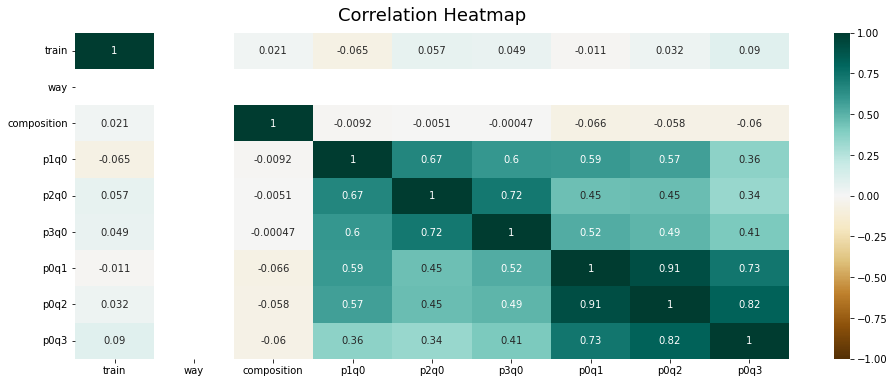

In [10]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(Xtrain.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

### (Pearson's Correlation)[https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html]

In [11]:
# Pearson's Correlation doesn't allow NaNs
tempdf = Xtrain.dropna()

print("Train / Way:         ", pearsonr(tempdf["train"], tempdf["way"]))
print("Train / Composition: ", pearsonr(tempdf["train"], tempdf["composition"]))
print("Train / p1q0:        ", pearsonr(tempdf["train"], tempdf["p1q0"]))
print("Train / p2q0:        ", pearsonr(tempdf["train"], tempdf["p2q0"]))
print("Train / p3q0:        ", pearsonr(tempdf["train"], tempdf["p3q0"]))
print("Train / p0q1:        ", pearsonr(tempdf["train"], tempdf["p0q1"]))
print("Train / p0q2:        ", pearsonr(tempdf["train"], tempdf["p0q2"]))
print("Train / p0q3:        ", pearsonr(tempdf["train"], tempdf["p0q3"]))

print("\nWay / Composition:   ", pearsonr(tempdf["way"], tempdf["composition"]))
print("Way / p1q0:          ", pearsonr(tempdf["way"], tempdf["p1q0"]))
print("Way / p2q0:          ", pearsonr(tempdf["way"], tempdf["p2q0"]))
print("Way / p3q0:          ", pearsonr(tempdf["way"], tempdf["p3q0"]))
print("Way / p0q1:          ", pearsonr(tempdf["way"], tempdf["p0q1"]))
print("Way / p0q2:          ", pearsonr(tempdf["way"], tempdf["p0q2"]))
print("Way / p0q3:          ", pearsonr(tempdf["way"], tempdf["p0q3"]))

print("\nComposition / p1q0:          ", pearsonr(tempdf["composition"], tempdf["p1q0"]))
print("Composition / p2q0:          ", pearsonr(tempdf["composition"], tempdf["p2q0"]))
print("Composition / p3q0:          ", pearsonr(tempdf["composition"], tempdf["p3q0"]))
print("Composition / p0q1:          ", pearsonr(tempdf["composition"], tempdf["p0q1"]))
print("Composition / p0q2:          ", pearsonr(tempdf["composition"], tempdf["p0q2"]))
print("Composition / p0q3:          ", pearsonr(tempdf["composition"], tempdf["p0q3"]))

print("\np1q0 / p2q0:          ", pearsonr(tempdf["p1q0"], tempdf["p2q0"]))
print("p1q0 / p3q0:          ", pearsonr(tempdf["p1q0"], tempdf["p3q0"]))
print("p1q0 / p0q1:          ", pearsonr(tempdf["p1q0"], tempdf["p0q1"]))
print("p1q0 / p0q2:          ", pearsonr(tempdf["p1q0"], tempdf["p0q2"]))
print("p1q0 / p0q3:          ", pearsonr(tempdf["p1q0"], tempdf["p0q3"]))

print("\np2q0 / p3q0:          ", pearsonr(tempdf["p2q0"], tempdf["p3q0"]))
print("p2q0 / p0q1:          ", pearsonr(tempdf["p2q0"], tempdf["p0q1"]))
print("p2q0 / p0q2:          ", pearsonr(tempdf["p2q0"], tempdf["p0q2"]))
print("p2q0 / p0q3:          ", pearsonr(tempdf["p2q0"], tempdf["p0q3"]))

print("\np3q0 / p0q1:          ", pearsonr(tempdf["p3q0"], tempdf["p0q1"]))
print("p3q0 / p0q2:          ", pearsonr(tempdf["p3q0"], tempdf["p0q2"]))
print("p3q0 / p0q3:          ", pearsonr(tempdf["p3q0"], tempdf["p0q3"]))

print("\np0q1 / p0q2:          ", pearsonr(tempdf["p0q1"], tempdf["p0q2"]))
print("p0q1 / p0q3:          ", pearsonr(tempdf["p0q1"], tempdf["p0q3"]))

print("\np0q1 / p0q3:          ", pearsonr(tempdf["p0q2"], tempdf["p0q3"]))

Train / Way:          (nan, nan)
Train / Composition:  (0.02396390915877052, 0.001445744416096438)
Train / p1q0:         (-0.09028173979490059, 2.6781457202907575e-33)
Train / p2q0:         (0.07293782208736876, 2.824255376368441e-22)
Train / p3q0:         (0.0756577705896897, 7.523611511419784e-24)
Train / p0q1:         (-0.039710223306996154, 1.2937163730604964e-07)
Train / p0q2:         (0.019661102022398104, 0.008967421352482303)
Train / p0q3:         (0.08756847255685932, 2.0257745764395686e-31)

Way / Composition:    (nan, nan)
Way / p1q0:           (nan, nan)
Way / p2q0:           (nan, nan)
Way / p3q0:           (nan, nan)
Way / p0q1:           (nan, nan)
Way / p0q2:           (nan, nan)
Way / p0q3:           (nan, nan)

Composition / p1q0:           (-0.008425420022724183, 0.26280209150533396)
Composition / p2q0:           (-0.009007573765873475, 0.2312411671656574)
Composition / p3q0:           (-0.00503208388226695, 0.5036302011961264)
Composition / p0q1:           (-0.08537

C:\Users\Ghast\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


### (Spearman's Correlation)[https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html]

In [12]:
print("Train / Way:         ", spearmanr(tempdf["train"], tempdf["way"]))
print("Train / Composition: ", spearmanr(tempdf["train"], tempdf["composition"]))
print("Train / p1q0:        ", spearmanr(tempdf["train"], tempdf["p1q0"]))
print("Train / p2q0:        ", spearmanr(tempdf["train"], tempdf["p2q0"]))
print("Train / p3q0:        ", spearmanr(tempdf["train"], tempdf["p3q0"]))
print("Train / p0q1:        ", spearmanr(tempdf["train"], tempdf["p0q1"]))
print("Train / p0q2:        ", spearmanr(tempdf["train"], tempdf["p0q2"]))
print("Train / p0q3:        ", spearmanr(tempdf["train"], tempdf["p0q3"]))

print("\nWay / Composition:   ", spearmanr(tempdf["way"], tempdf["composition"]))
print("Way / p1q0:          ", spearmanr(tempdf["way"], tempdf["p1q0"]))
print("Way / p2q0:          ", spearmanr(tempdf["way"], tempdf["p2q0"]))
print("Way / p3q0:          ", spearmanr(tempdf["way"], tempdf["p3q0"]))
print("Way / p0q1:          ", spearmanr(tempdf["way"], tempdf["p0q1"]))
print("Way / p0q2:          ", spearmanr(tempdf["way"], tempdf["p0q2"]))
print("Way / p0q3:          ", spearmanr(tempdf["way"], tempdf["p0q3"]))

print("\nComposition / p1q0:          ", spearmanr(tempdf["composition"], tempdf["p1q0"]))
print("Composition / p2q0:          ", spearmanr(tempdf["composition"], tempdf["p2q0"]))
print("Composition / p3q0:          ", spearmanr(tempdf["composition"], tempdf["p3q0"]))
print("Composition / p0q1:          ", spearmanr(tempdf["composition"], tempdf["p0q1"]))
print("Composition / p0q2:          ", spearmanr(tempdf["composition"], tempdf["p0q2"]))
print("Composition / p0q3:          ", spearmanr(tempdf["composition"], tempdf["p0q3"]))

print("\np1q0 / p2q0:          ", spearmanr(tempdf["p1q0"], tempdf["p2q0"]))
print("p1q0 / p3q0:          ", spearmanr(tempdf["p1q0"], tempdf["p3q0"]))
print("p1q0 / p0q1:          ", spearmanr(tempdf["p1q0"], tempdf["p0q1"]))
print("p1q0 / p0q2:          ", spearmanr(tempdf["p1q0"], tempdf["p0q2"]))
print("p1q0 / p0q3:          ", spearmanr(tempdf["p1q0"], tempdf["p0q3"]))

print("\np2q0 / p3q0:          ", spearmanr(tempdf["p2q0"], tempdf["p3q0"]))
print("p2q0 / p0q1:          ", spearmanr(tempdf["p2q0"], tempdf["p0q1"]))
print("p2q0 / p0q2:          ", spearmanr(tempdf["p2q0"], tempdf["p0q2"]))
print("p2q0 / p0q3:          ", spearmanr(tempdf["p2q0"], tempdf["p0q3"]))

print("\np3q0 / p0q1:          ", spearmanr(tempdf["p3q0"], tempdf["p0q1"]))
print("p3q0 / p0q2:          ", spearmanr(tempdf["p3q0"], tempdf["p0q2"]))
print("p3q0 / p0q3:          ", spearmanr(tempdf["p3q0"], tempdf["p0q3"]))

print("\np0q1 / p0q2:          ", spearmanr(tempdf["p0q1"], tempdf["p0q2"]))
print("p0q1 / p0q3:          ", spearmanr(tempdf["p0q1"], tempdf["p0q3"]))

print("\np0q1 / p0q3:          ", spearmanr(tempdf["p0q2"], tempdf["p0q3"]))

C:\Users\Ghast\anaconda3\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Train / Way:          SpearmanrResult(correlation=nan, pvalue=nan)
Train / Composition:  SpearmanrResult(correlation=0.024452932534256507, pvalue=0.0011525049669096044)
Train / p1q0:         SpearmanrResult(correlation=-0.09835920079588018, pvalue=3.118367945070693e-39)
Train / p2q0:         SpearmanrResult(correlation=0.047000473896123704, pvalue=4.1042745655065747e-10)
Train / p3q0:         SpearmanrResult(correlation=0.08377763372173284, pvalue=6.845584997536671e-29)
Train / p0q1:         SpearmanrResult(correlation=-0.02508757091753864, pvalue=0.0008537124692371213)
Train / p0q2:         SpearmanrResult(correlation=0.01029941419529029, pvalue=0.1710397005945195)
Train / p0q3:         SpearmanrResult(correlation=0.004544385629831213, pvalue=0.5458631861479014)

Way / Composition:    SpearmanrResult(correlation=nan, pvalue=nan)
Way / p1q0:           SpearmanrResult(correlation=nan, pvalue=nan)
Way / p2q0:           SpearmanrResult(correlation=nan, pvalue=nan)
Way / p3q0:           Sp

### Independent to Dependent Variable Correlation (Simply the heatmap ordered from most influential to least influential)

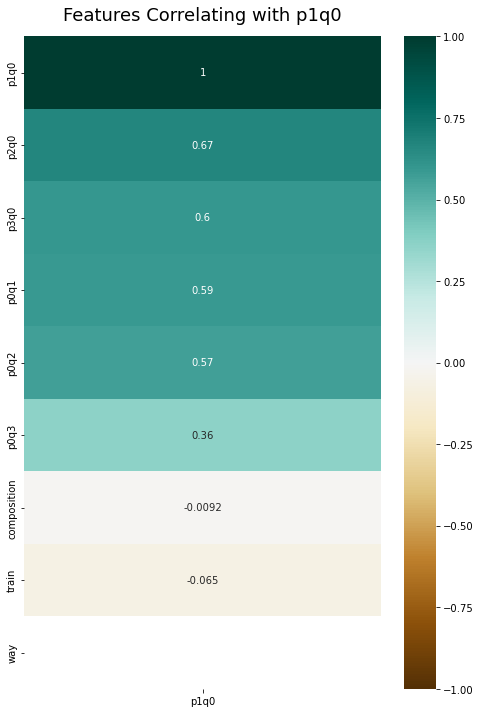

In [13]:
Xtrain.corr()[['p1q0']].sort_values(by='p1q0', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(Xtrain.corr()[['p1q0']].sort_values(by='p1q0', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with p1q0', fontdict={'fontsize':18}, pad=16);

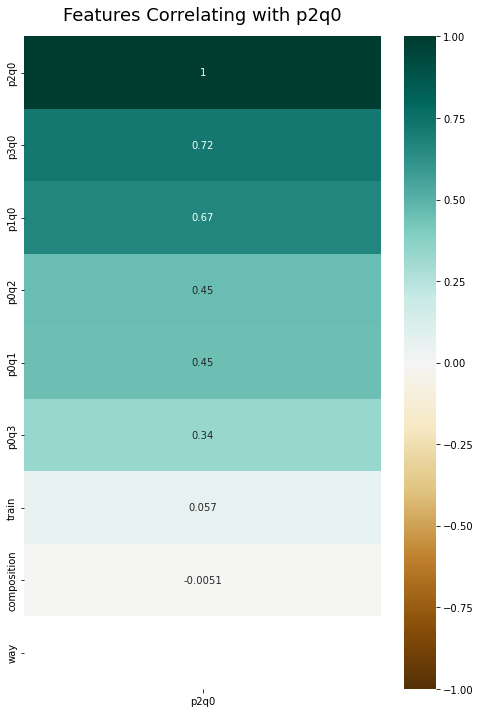

In [14]:
Xtrain.corr()[['p2q0']].sort_values(by='p2q0', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(Xtrain.corr()[['p2q0']].sort_values(by='p2q0', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with p2q0', fontdict={'fontsize':18}, pad=16);

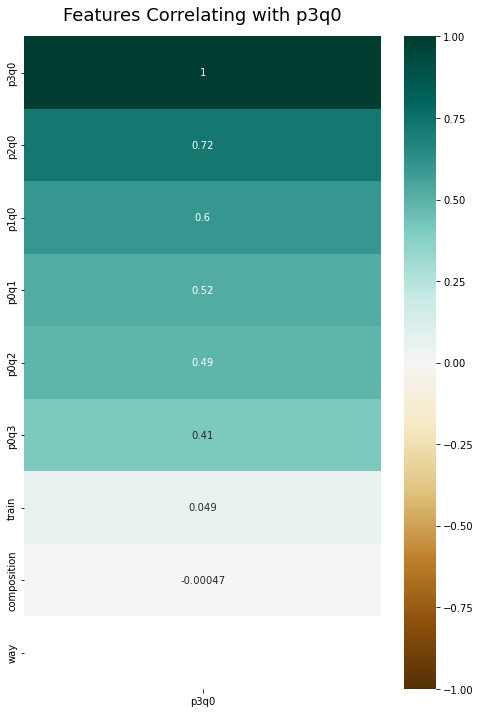

In [15]:
Xtrain.corr()[['p3q0']].sort_values(by='p3q0', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(Xtrain.corr()[['p3q0']].sort_values(by='p3q0', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with p3q0', fontdict={'fontsize':18}, pad=16);

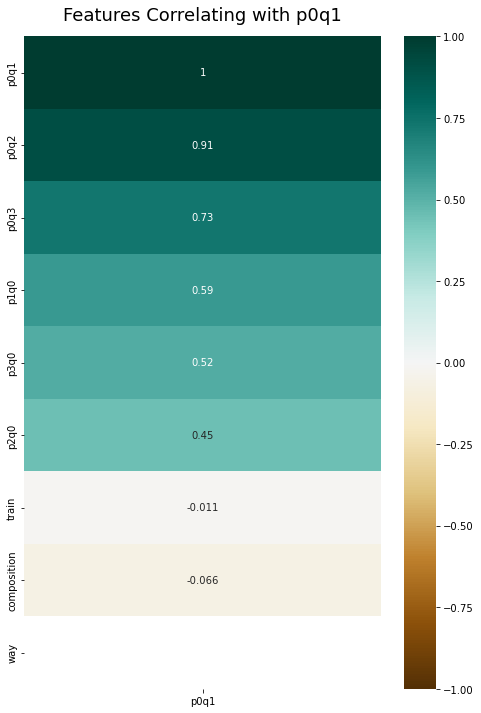

In [16]:
Xtrain.corr()[['p0q1']].sort_values(by='p0q1', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(Xtrain.corr()[['p0q1']].sort_values(by='p0q1', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with p0q1', fontdict={'fontsize':18}, pad=16);

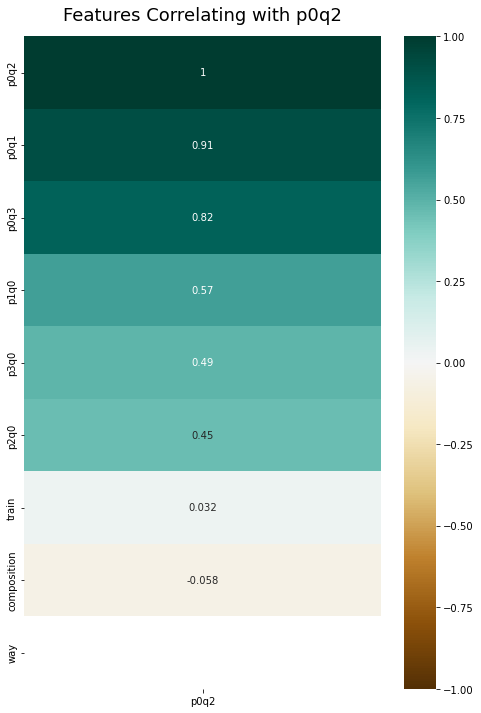

In [17]:
Xtrain.corr()[['p0q2']].sort_values(by='p0q2', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(Xtrain.corr()[['p0q2']].sort_values(by='p0q2', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with p0q2', fontdict={'fontsize':18}, pad=16);

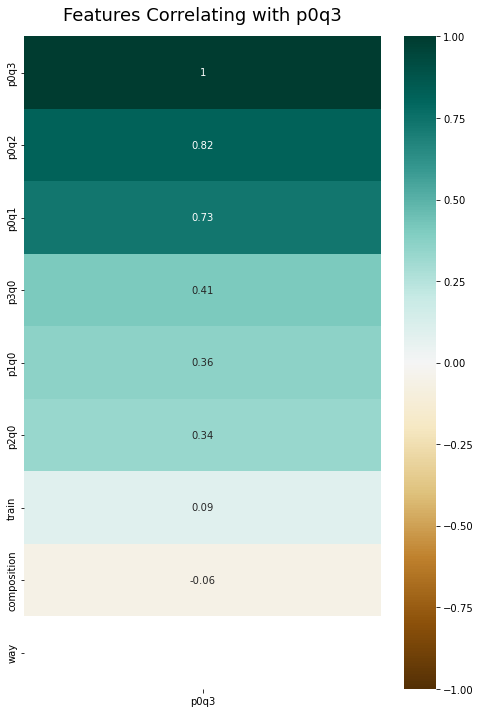

In [18]:
Xtrain.corr()[['p0q3']].sort_values(by='p0q3', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(Xtrain.corr()[['p0q3']].sort_values(by='p0q3', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with p0q3', fontdict={'fontsize':18}, pad=16);